In [1]:
import pdfplumber # Go to https://github.com/jsvine/pdfplumber for installation instructions and explanation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

In [21]:
#loading files
path = r'../floor_plans/'
fps = os.listdir(path)
f = fps[0]
file_1 = pdfplumber.open(path +f).pages[0]

In [3]:
# For making a reresentation of a symbol
def create_symbol_sig(fp,idx, n_parts):
    ppoint = find_distances(fp.curves[idx:idx+n_parts])
    full_dict = {}
    full_dict['distances'] = ppoint
    full_dict['total_points'] = len(ppoint)
    return full_dict

In [4]:
#takes in two sets of coordinates and returns a floating point value
def euc_dist(a, b):    
    d = np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    return float(d)

# find the distance from the first point to all other points in the curve set and save them
# accepts a list of coord tuples and returns a list of floating point values 
def find_distances(c_list):
    d_list = []
    base = c_list[0]['points'][0]
    for c in c_list:
        points = c['points']
        for i in range(0, len(points)):
            d_list.append(euc_dist(base, points[i]))
        
    return d_list

# matches the template to the tested curves by using abs. differences
# l1 will be the template and l2 the tested
# accepts two lists and returns a list of values
def compare_distances(l1, l2):
    diff = []
    
    if len(l1) == len(l2):
        for i in range(0, len(l1)):
            diff.append(np.abs(l2[i] - l1[i]))
    
    return diff

In [5]:
# functions for symbol matching

def match_symbols(file, sym, idx):
    # compare distances to get a difference val
    # l1 and l2 are lists of equal size
    l1 = sym['distances']
    l2 = find_distances(file.curves[idx : idx + sym['components']]) 
    diff = compare_distances(l1, l2)
    # discriminate base on that val 
    return diff

# find the first point for those that match the symbol
def get_matches(file, sym, tol = 1):
    matches = {}
    for i in range(0, len(file.curves) - sym['components']):    
        scores = match_symbols(file, sym, i)
        # add the idx val if it is a match and skip, otherwise do next 
        if len(scores) > 0 and sum(scores) < tol:
            matches[i] = scores
            
    return matches

In [24]:
# Loading in the outlets file
with open("../symbols/outlets.json", "r") as infile:
    symbols = json.load(infile)
    
# setting up the visualisation tool
im = file_1.to_image(resolution = 108)

23


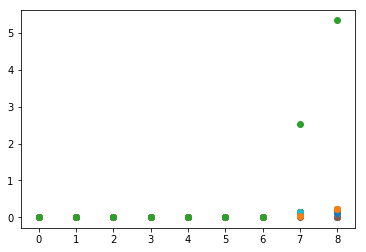

In [22]:
sym = symbols['a']['01']

results  = get_matches(file_1, sym, max(sym['distances']))
print(len(results))

for key in results.keys():
    plt.scatter(range(0, len(results[key])), results[key])
plt.show()

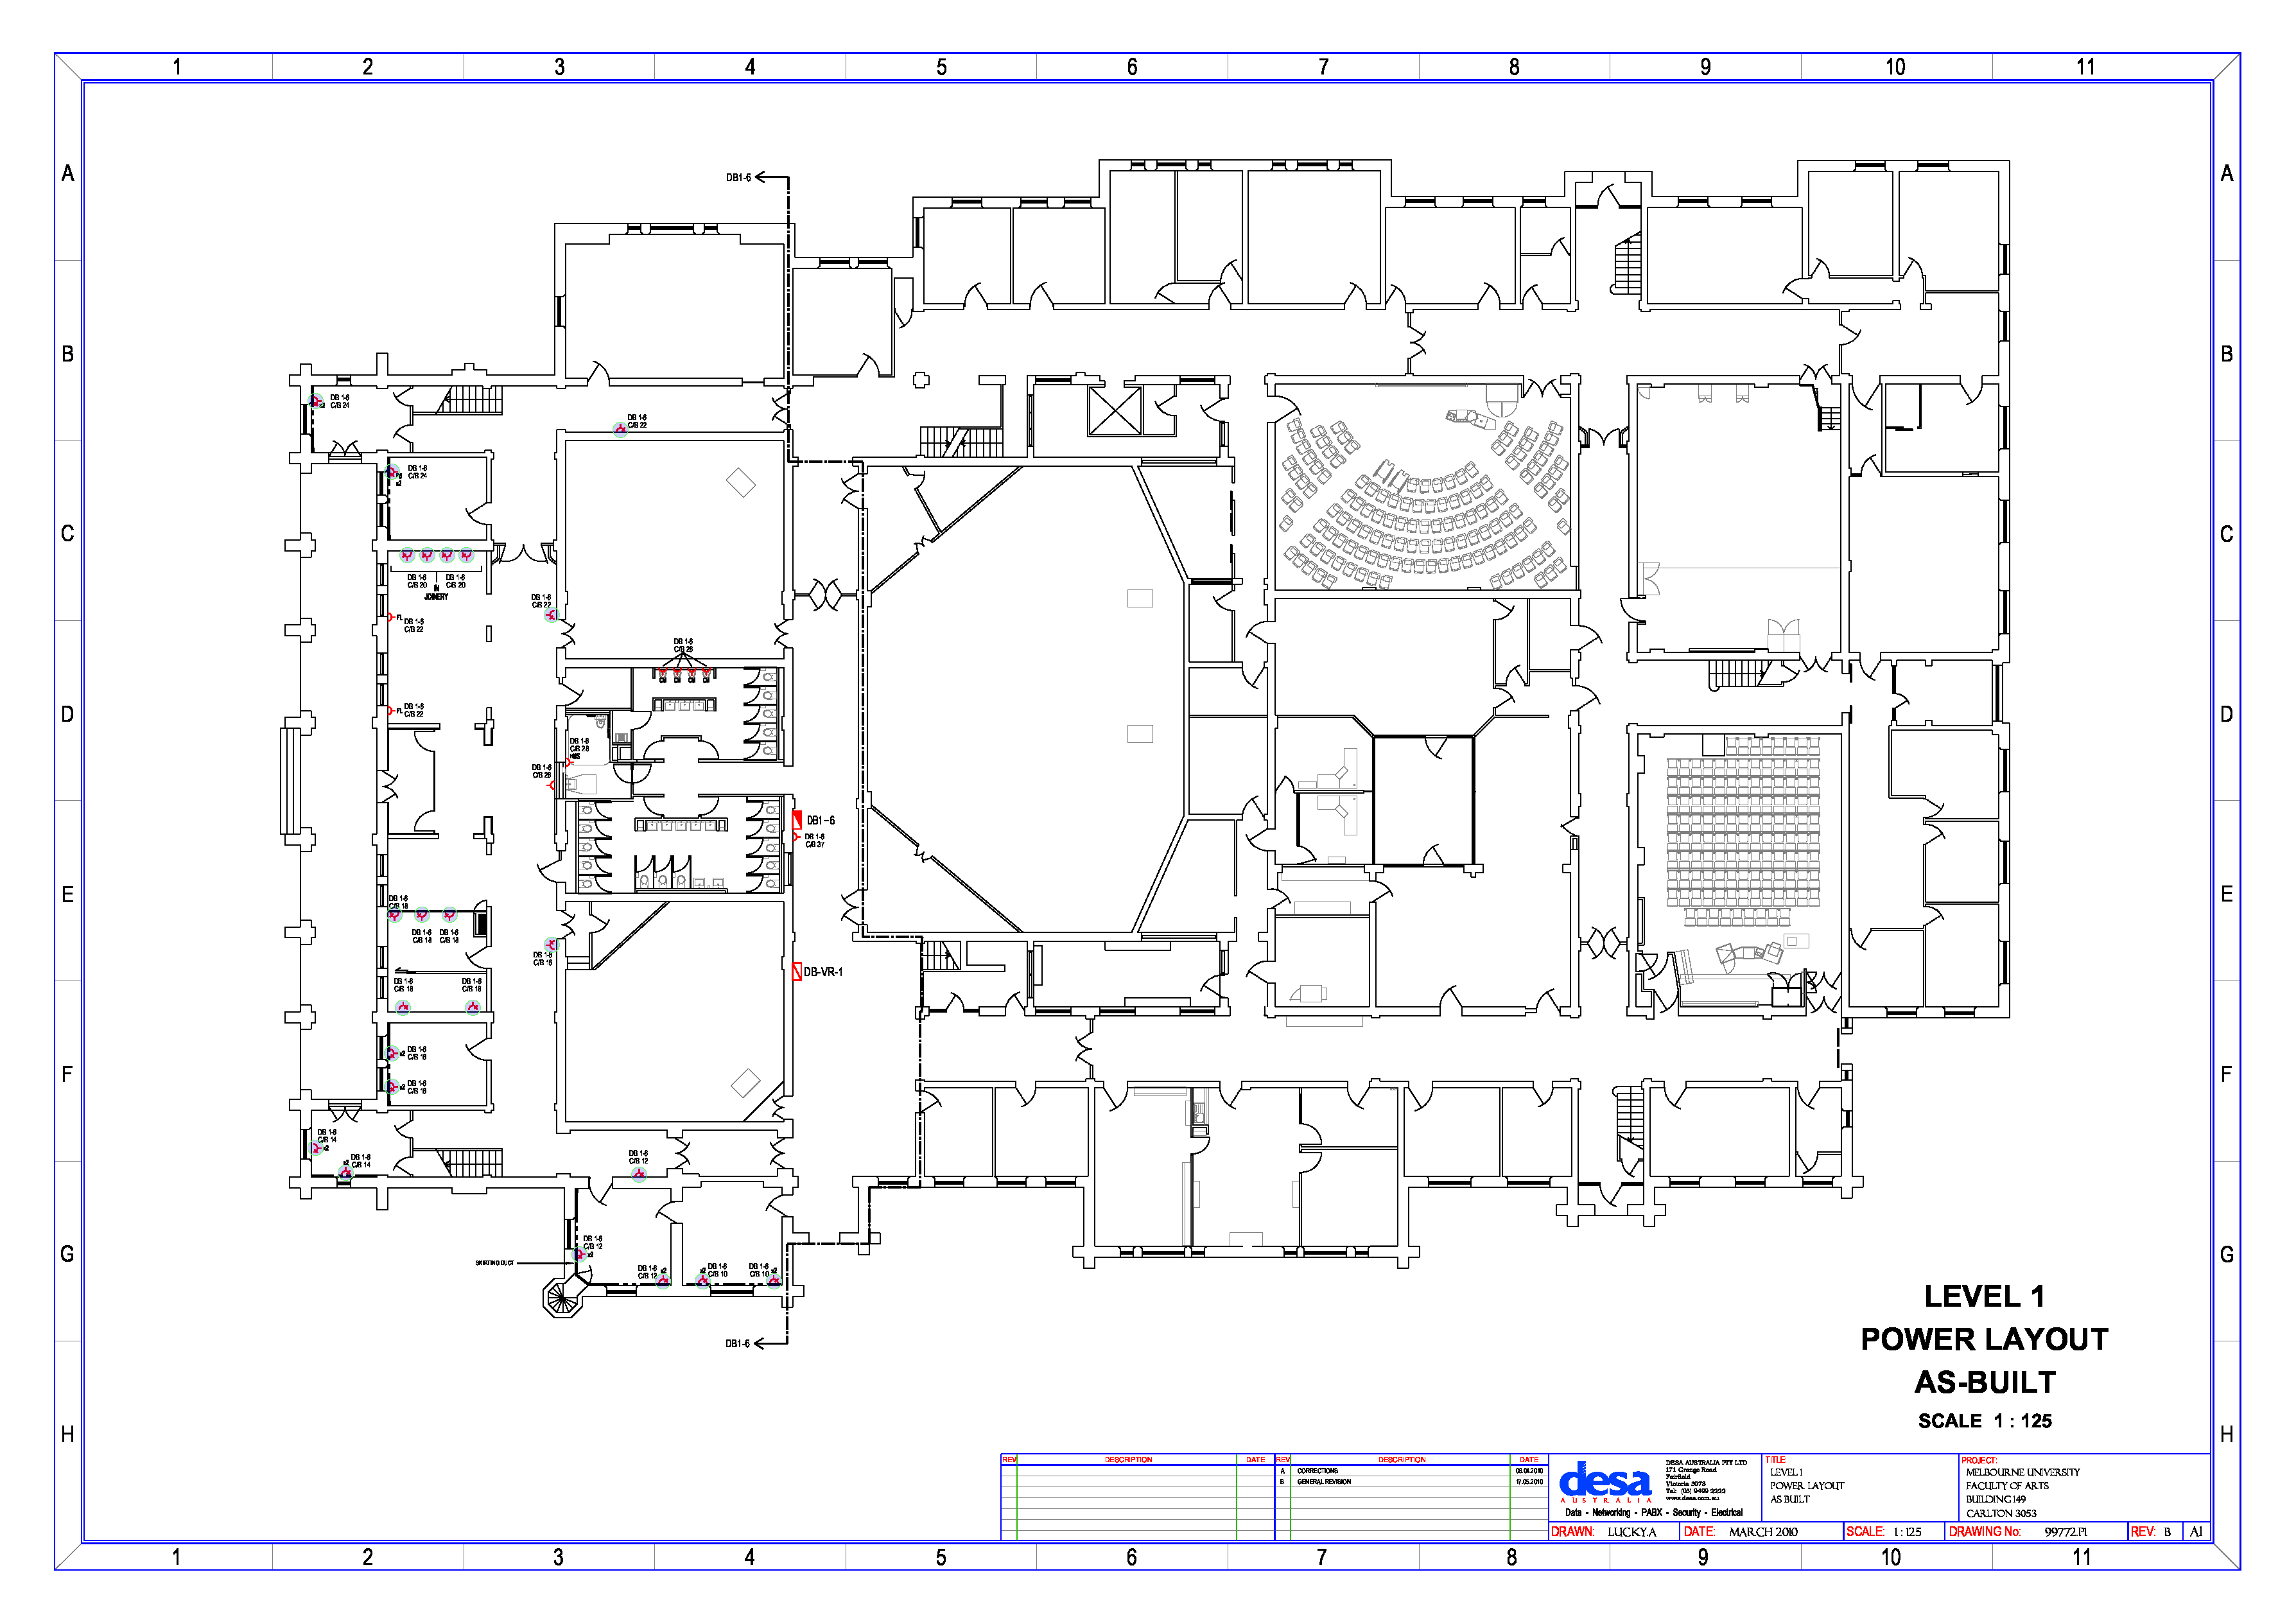

In [25]:
# visualising on the floorplan
im.reset()
for r in results:
    im.draw_circle(file_1.curves[r], stroke='#66FF66', radius = 8)
im

In [9]:
# recieve an index val and the pdf file
# return the mean x,y vals for the given curve
def get_xy(key, file):
    x = float(file.curves[key]["x1"] + file.curves[key]["x0"])/2
    y = float(file.curves[key]["y1"] + file.curves[key]["y0"])/2
    
    return x, y

# recieive a dictionary of the starting keys and the distance list for each match 
# output a table of schema <id, type, x, y, distances>
def get_outputs(matches, a_type, file):
    table = pd.DataFrame(columns = ["id", "type", "x", "y", "distances"])
    
    for m in matches:
        x, y = get_xy(m, file)
        table = table.append({"id": m, "type": a_type, "x": x, "y": y, "distances": matches[m]}, ignore_index = True)
    return table

In [26]:
#exporting table and saving in the outputs folder
get_outputs(results, "A", file_1).to_csv(r"../outputs/{}_assets.csv".format(f[:-4]))